# Classification using LDA, QDA, and Logistic Regression

In this example, we will classify patient as being dead or not, given a Covid-19 patient's current symptom, status, and medical history. Logistic regression, linear discriminant analysis and quadratic discriminant analysis will be used.

The dataset contains 1048576 rows and 21 unique features:


sex: 1 for female and 2 for male.

age: of the patient.

classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.

patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.

pneumonia: whether the patient already have air sacs inflammation or not.

pregnancy: whether the patient is pregnant or not.

diabetes: whether the patient has diabetes or not.

copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.

asthma: whether the patient has asthma or not.

inmsupr: whether the patient is immunosuppressed or not.

hypertension: whether the patient has hypertension or not.

cardiovascular: whether the patient has heart or blood vessels related disease.

renal chronic: whether the patient has chronic renal disease or not.

other disease: whether the patient has other disease or not.

obesity: whether the patient is obese or not.

tobacco: whether the patient is a tobacco user.

usmr: Indicates whether the patient treated medical units of the first, second or third level.

medical unit: type of institution of the National Health System that provided the care.

intubed: whether the patient was connected to the ventilator.

icu: Indicates whether the patient had been admitted to an Intensive Care Unit.

date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

## Load and read the data

### Import libraries 

🐼 Importing Pandas and NumPy
- These are standard imports for data manipulation and numerical computations. Pandas is used for data processing and analysis, while NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, etc 🧮

🎨 Visualization Libraries
- Matplotlib and Seaborn are two powerful libraries for creating static, animated, and interactive visualizations in Python. Seaborn is built on top of Matplotlib and provides a high-level interface for drawing attractive and informative statistical graphics 📊

🔍 Scikit-Learn for Machine Learning:
- LabelEncoder is used for encoding labels with value between 0 and n_classes-1 🏷️
- 🔀 train_test_split, cross_val_score are tools for splitting datasets into training and test sets, and for evaluating performance using cross-validation.
- roc_curve, auc, confusion_matrix are imported for evaluating the performance of a classification model. These functions help in understanding how well the model distinguishes between classes 📈

📉 Setting Up Matplotlib Inline
- %matplotlib inline is a magic command for Jupyter Notebooks that enables plots created by Matplotlib to be displayed inline, directly below the corresponding code cell. This command is essential for visualizing plots directly in Jupyter Notebooks 📓 📉

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix

%matplotlib inline

### Load CSV

📂 Setting the Data File Path
- A preparatory step to ensure the correct file is accessed for data loading. 

🔄 Reading the CSV Data with Pandas
- Load data from the CSV file at the specified path into a DataFrame 📚

👀 Displaying the First Few Rows
- displays the first five rows of the DataFrame 🖥️

In [2]:
DATAPATH = 'Covid Data.csv'

data = pd.read_csv(DATAPATH)
data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


### Reforming 

🔄 Transforming 'DATE_DIED' into a Binary 'DEAD' Column
- Transform the 'DATE_DIED' column into a new binary column 'DEAD'using a lambda function. to apply this transformation: if the death date is '9999-99-99' (no death), it assigns 'N' (Not Dead), otherwise 'Y' (Dead) 🔀

🗑️ Dropping the Original 'DATE_DIED' Column
- Remove the original 'DATE_DIED' column from the DataFrame, as it's no longer needed after the transformation into the 'DEAD' column. This helps in simplifying the dataset by removing redundant or unnecessary information 🧹

👀 Displaying the Updated DataFrame

In [3]:
data['DEAD'] = data['DATE_DIED'].apply(lambda x: 'N' if x == '9999-99-99' else 'Y')
data = data.drop(columns=['DATE_DIED'])
data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEAD
0,2,1,1,1,97,1,65,2,2,2,...,2,1,2,2,2,2,2,3,97,Y
1,2,1,2,1,97,1,72,97,2,2,...,2,1,2,2,1,1,2,5,97,Y
2,2,1,2,2,1,2,55,97,1,2,...,2,2,2,2,2,2,2,3,2,Y
3,2,1,1,1,97,2,53,2,2,2,...,2,2,2,2,2,2,2,7,97,Y
4,2,1,2,1,97,2,68,97,1,2,...,2,1,2,2,2,2,2,3,97,Y


### Creating a Count Plot with Seaborn
- Using Seaborn's countplot function to create a bar chart showing the counts of observations in each category of the 'DEAD' column. This is a straightforward way to visualize the distribution of binary data 📉

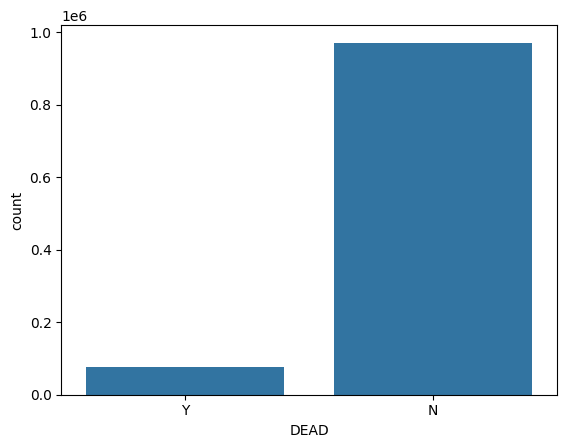

In [4]:
ax = sns.countplot(x = data['DEAD'], data=data)

### Defining a Function for Plotting Data

🖼️ Function
- plot_data that takes two parameters: hue and data. This function is designed to create count plots for each column in the DataFrame, with the ability to differentiate data points based on the hue parameter🖌️

🔁 Iterating Over DataFrame Columns
-Setting up a loop to iterate over each column in the DataFrame. The enumerate function is used to get both the index (i) and the column name (col) 

📈 Creating Count Plots for Each Column
- Inside the loop, plt.figure(i) creates a new figure for each iteration, ensuring that each plot is displayed in a separate figure. The hue parameter allows the plot to display different colors for different categories within the hue variable, providing a clear visual comparison 🌈

In [5]:
def plot_data(hue, data): 
    for i, col in enumerate(data.columns):
        plt.figure(i)
        ax = sns.countplot(x=data[col], hue=hue, data=data)

# plot_data(data['DEAD'], data.drop(columns=['DEAD']))

## Preprocessing

### Find Specific Missing Values

🔍 Iterating Over DataFrame Columns 
- This loop goes through and perform an operation on each column in the DataFrame data.

📊 Calculating Specific Missing Values
- The .isin([97, 99]) checks if the column values are either 97 or 99, which are presumably codes for missing or undefined data in this context. The .sum() then adds up all the instances where this condition is true, giving a total count of these specific missing values for each column. 🧮

🖨️ Printing Missing Values Count

In [6]:
for col in data.columns:
    missing_values = data[col].isin([97, 99]).sum()
    print(f"{col}: {missing_values}")

USMER: 0
MEDICAL_UNIT: 0
SEX: 0
PATIENT_TYPE: 0
INTUBED: 855869
PNEUMONIA: 16003
AGE: 221
PREGNANT: 523511
DIABETES: 0
COPD: 0
ASTHMA: 0
INMSUPR: 0
HIPERTENSION: 0
OTHER_DISEASE: 0
CARDIOVASCULAR: 0
OBESITY: 0
RENAL_CHRONIC: 0
TOBACCO: 0
CLASIFFICATION_FINAL: 0
ICU: 856032
DEAD: 0


### Processing

✅ Standardising Categorical Variables:
- Targeted columns representing medical conditions or patient attributes ('USMER', 'SEX', 'PATIENT_TYPE', 'DIABETES', 'ASTHMA', etc.), are standardised by replacing the value 2 with 0. This step suggests a re-encoding of binary data, making the dataset uniform and more intuitive for analysis. 

🗑️ Dropping Redundant Columns 
- The removal of columns like 'INTUBED','PNEUMONIA','PREGNANT','ICU' indicates a streamlining of the dataset due to their potential redundancy. This cleaning step helps in focusing the analysis on more impactful data 🔍

In [7]:
columns_to_replace = ['USMER', 'SEX', 'PATIENT_TYPE', 'DIABETES', 'ASTHMA', 
                      'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'COPD',
                      'CARDIOVASCULAR', 'OBESITY',  'RENAL_CHRONIC', 'TOBACCO']

data[columns_to_replace] = data[columns_to_replace].replace(2, 0)

columns_to_drop =['INTUBED','PNEUMONIA','PREGNANT','ICU']
data.drop(columns = columns_to_drop, inplace=True)
data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,DEAD
0,0,1,1,1,65,0,0,0,0,1,0,0,0,0,0,3,Y
1,0,1,0,1,72,0,0,0,0,1,0,0,1,1,0,5,Y
2,0,1,0,0,55,1,0,0,0,0,0,0,0,0,0,3,Y
3,0,1,1,1,53,0,0,0,0,0,0,0,0,0,0,7,Y
4,0,1,0,1,68,1,0,0,0,1,0,0,0,0,0,3,Y


### Filtering focusing on the 'AGE' column

Filtering Based on Age Values 🚫
- filter out rows where the 'AGE' column has values 97 or 99. These values might represent missing or outlier data in the context of age. This step ensures that the analysis is based on more reliable and meaningful age data

Applying the Filter to the DataFrame 🧹
- Effectively removes rows with the specified age values, refining the dataset for more accurate analysis. 

Identifying the Maximum Age 🏆
- Computes the maximum age in the filtered dataset. This is an important step for understanding the age range of the data, particularly the upper limit, after cleaning.

In [8]:
condition = (data['AGE'] != 97) & (data['AGE'] != 99)
data = data[condition]
largest_value = data['AGE'].max()
largest_value

121

### Categorising continuous age data into discrete age groups
Defining Age Bins 📐
- bin_edges lists the boundaries for the age groups, effectively segmenting ages into bins like 0-17, 18-29, 30-39, etc., up to 121. This categorization helps in analyzing the data across different age groups, making the insights more specific and actionable 📊

Creating Age Group Labels 🏷️
- bin_labels provides a set of labels corresponding to the age bins. These labels are more reader-friendly and provide a clear understanding of each age group, enhancing the interpretability of the analysis results 📝

Binning the Age Data 🗃️
- Categorize each individual's age into the defined age groups. The right=False parameter indicates that the right edge of the bin is not included in the bin (i.e., the bins are left-inclusive) 🔄

In [9]:
bin_edges = [0, 18, 30, 40, 50, 60, 70, 80, 90, 121]
bin_labels = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89','90-121']

data.loc[:, 'AGE_GROUPE'] = pd.cut(data['AGE'], bins=bin_edges, labels=bin_labels, right=False)
print(data[['AGE', 'AGE_GROUPE']].head())

   AGE AGE_GROUPE
0   65      60-69
1   72      70-79
2   55      50-59
3   53      50-59
4   68      60-69


### Further refines the dataset

Encoding the 'DEAD' Column 🔢
- Initializes a label encoder instance from scikit-learn, a handy tool for encoding labels with a value between 0 and the number of classes minus 1. Converts categorical labels into a numeric format, making the data suitable for various types of analysis, especially those involving machine learning algorithms. 

One-Hot Encoding Remaining Categorical Variables🔥
- A common technique to convert categorical variables into a format that can be provided to machine learning algorithms to do a better job in prediction. 

In [10]:
data = data.drop(columns=['AGE'])

le = LabelEncoder()

data['DEAD'] = le.fit_transform(data['DEAD'])

encoded_data = pd.get_dummies(data) 
encoded_data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,...,DEAD,AGE_GROUPE_0-17,AGE_GROUPE_18-29,AGE_GROUPE_30-39,AGE_GROUPE_40-49,AGE_GROUPE_50-59,AGE_GROUPE_60-69,AGE_GROUPE_70-79,AGE_GROUPE_80-89,AGE_GROUPE_90-121
0,0,1,1,1,0,0,0,0,1,0,...,1,False,False,False,False,False,True,False,False,False
1,0,1,0,1,0,0,0,0,1,0,...,1,False,False,False,False,False,False,True,False,False
2,0,1,0,0,1,0,0,0,0,0,...,1,False,False,False,False,True,False,False,False,False
3,0,1,1,1,0,0,0,0,0,0,...,1,False,False,False,False,True,False,False,False,False
4,0,1,0,1,1,0,0,0,1,0,...,1,False,False,False,False,False,True,False,False,False


### Final data frame

In [11]:
columns_to_convert = ['AGE_GROUPE_0-17','AGE_GROUPE_18-29',
                      'AGE_GROUPE_30-39','AGE_GROUPE_40-49',
                      'AGE_GROUPE_50-59','AGE_GROUPE_60-69',
                      'AGE_GROUPE_70-79','AGE_GROUPE_80-89',
                      'AGE_GROUPE_90-121']

encoded_data[columns_to_convert] = encoded_data[columns_to_convert].replace({True: 1, False: 0})

encoded_data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,...,DEAD,AGE_GROUPE_0-17,AGE_GROUPE_18-29,AGE_GROUPE_30-39,AGE_GROUPE_40-49,AGE_GROUPE_50-59,AGE_GROUPE_60-69,AGE_GROUPE_70-79,AGE_GROUPE_80-89,AGE_GROUPE_90-121
0,0,1,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
1,0,1,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,1,1,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,1,0,1,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0


## Model

In [12]:
y = encoded_data['DEAD'].values.reshape(-1, 1)
X = encoded_data.drop(['DEAD'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)

## Logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression(max_iter=1000)

logistic_reg.fit(X_train, y_train.ravel())

y_prob = logistic_reg.predict_proba(X_test)[:,1]
y_pred = np.where(y_prob > 0.5, 1, 0)

In [14]:
log_confusion_matrix = confusion_matrix(y_test, y_pred)
log_confusion_matrix

array([[189936,   4344],
       [  9130,   6261]])

In [15]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9482672818611243

In [16]:
def plot_roc(roc_auc):
    plt.figure(figsize=(7,7))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color='red', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.axis('tight')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')

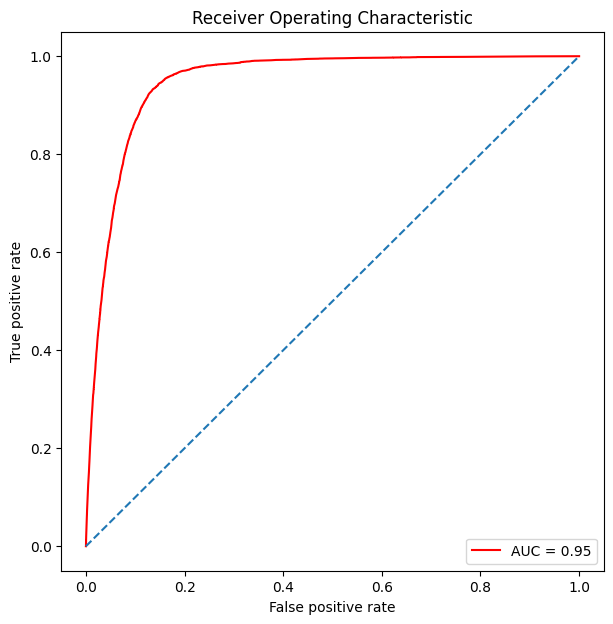

In [17]:
plot_roc(roc_auc)

## LDA (Linear Discriminant Analysis)

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train.ravel())

y_prob_lda = lda.predict_proba(X_test)[:,1]
y_pred_lda = np.where(y_prob_lda > 0.5, 1, 0)

In [19]:
lda_confusion_matrix = confusion_matrix(y_test, y_pred_lda)
lda_confusion_matrix

array([[182354,  11926],
       [  4576,  10815]])

In [20]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob_lda)
roc_auc_lda = auc(false_positive_rate, true_positive_rate)
roc_auc_lda

0.9447809059255851

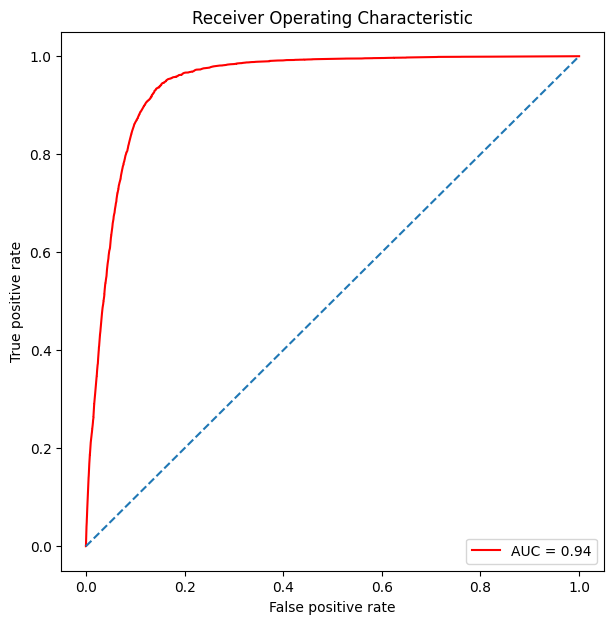

In [21]:
plot_roc(roc_auc_lda)

## QDA (Quadratic Discriminant Analysis) 

In [22]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train.ravel())

y_prob_qda = qda.predict_proba(X_test)[:,1]
y_pred_qda = np.where(y_prob_qda > 0.5, 1, 0)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [23]:
qda_confusion_matrix = confusion_matrix(y_test, y_pred_qda)
qda_confusion_matrix

array([[ 71897, 122383],
       [   434,  14957]])

In [24]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob_qda)
roc_auc_qda = auc(false_positive_rate, true_positive_rate)
roc_auc_qda

0.9046224980983314

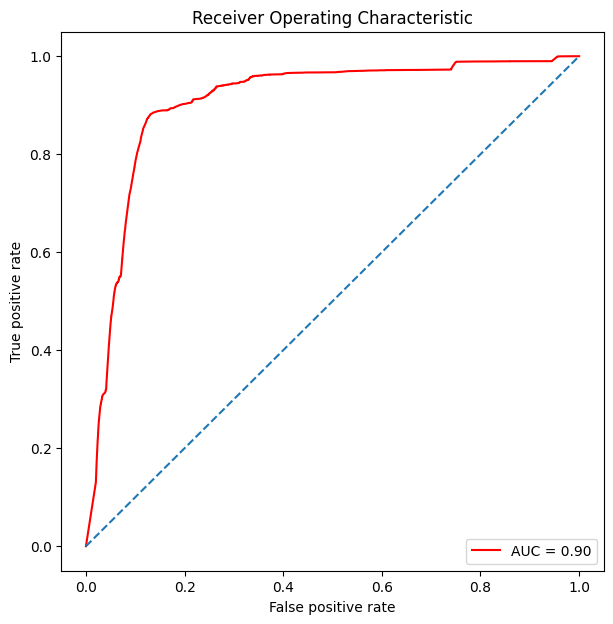

In [25]:
plot_roc(roc_auc_qda)

## Comparing the models using ROC curves

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


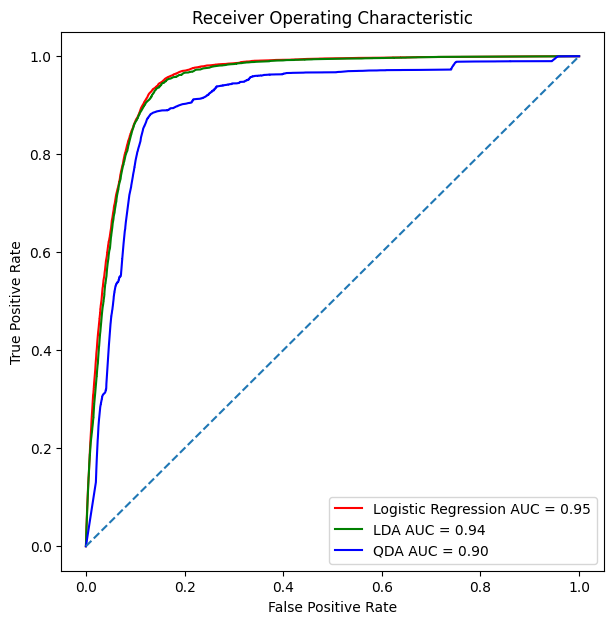

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)


logistic_reg = LogisticRegression(max_iter=1000)
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()


logistic_reg.fit(X_train, y_train.ravel())
lda.fit(X_train, y_train.ravel())
qda.fit(X_train, y_train.ravel())


y_prob_log = logistic_reg.predict_proba(X_test)[:,1]
y_prob_lda = lda.predict_proba(X_test)[:,1]
y_prob_qda = qda.predict_proba(X_test)[:,1]


fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_lda, tpr_lda, _ = roc_curve(y_test, y_prob_lda)
roc_auc_lda = auc(fpr_lda, tpr_lda)

fpr_qda, tpr_qda, _ = roc_curve(y_test, y_prob_qda)
roc_auc_qda = auc(fpr_qda, tpr_qda)


plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_log, tpr_log, color='red', label=f'Logistic Regression AUC = {roc_auc_log:.2f}')
plt.plot(fpr_lda, tpr_lda, color='green', label=f'LDA AUC = {roc_auc_lda:.2f}')
plt.plot(fpr_qda, tpr_qda, color='blue', label=f'QDA AUC = {roc_auc_qda:.2f}')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
